In [1]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from transformers import TrainerCallback
from datasets import load_dataset
from transformers import AutoTokenizer
from datetime import datetime

from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import evaluate
import json

import torch
torch.cuda.empty_cache()


c:\Users\Revalda Putawara\.conda\envs\mbgsentiment\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [3]:
files = {
    "train": r"dataset/train/train.csv", 
    "eval": r"dataset/train/eval.csv", 
    "test": r"dataset/train/test.csv",
}

dataset = load_dataset('csv', data_files=files)

## Tokenizer and Model load

In [ ]:
#"indolem/indobert-base-uncased" ==> can't predict class 1

#indolem/indobert-base-uncased
#ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa
#cahya/bert-base-indonesian-522M
#google-bert/bert-base-uncased

# key value pair. key will be supplied to model_choice variable
model_name = {"indobert_base":"indobenchmark/indobert-base-p2",
              "indobert_large":"indobenchmark/indobert-large-p2",
              "ayamerushia":"ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa",
              "cahya":"cahya/bert-base-indonesian-522M",
              "google-bert":"google-bert/bert-base-uncased"}

In [ ]:
NUMEPOCHTRAIN = 10
model_choice = "indobert_large"
model_serial = model_choice + "_" + datetime.strftime(datetime.now(),format="%y%m%d-%H%M%S")

print(model_serial)

cahya_250209-234327


In [ ]:
#model_serial = "indobert_base_250209-200104"
#print(model_serial)

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name[model_choice])

In [7]:
def tokenize_function(text):
    return tokenizer(text["text"], padding='max_length', max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 91/91 [00:00<00:00, 3126.82 examples/s]


In [8]:
train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["eval"]

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(model_name[model_choice], 
                                                           num_labels=3,
                                                           hidden_dropout_prob=0.3, 
                                                           attention_probs_dropout_prob=0.3
                                                           )

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
training_args = TrainingArguments(
    "test_trainer_"+model_serial, 
    per_device_train_batch_size=4, #no effect on training time
    per_device_eval_batch_size=4, # no effect on training time
    num_train_epochs=NUMEPOCHTRAIN,
    #label_names=["label"],
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    metric_for_best_model="eval_loss", 
    greater_is_better=False,
    save_total_limit = 2,
    load_best_model_at_end=False,
    save_strategy = "epoch",
    #save_strategy = "no",
    #report_to="tensorboard"
)

C:\Users\Revalda Putawara\AppData\Roaming\Python\Python312\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
accuracy = evaluate.load("accuracy")

In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return accuracy.compute(predictions=predictions, references=labels)

In [13]:
f1_metric = evaluate.load("f1")

def compute_f1(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    return f1_metric.compute(predictions=predictions, references=labels)

In [ ]:
class CustomCallback(TrainerCallback):
    
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer
    
    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train")
            return control_copy

## Start Training

In [ ]:
# Start TensorBoard before training to monitor it in progress
#%load_ext tensorboard
#%tensorboard --logdir '{model_output_dir}'/runs

In [14]:
torch.cuda.empty_cache()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

#trainer.add_callback(CustomCallback(trainer))

training_history = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.728500,0.834459,0.766871
2,0.634900,0.873982,0.800000
3,0.601400,0.595752,0.813497
4,0.538300,0.871504,0.813497
5,0.482800,0.786449,0.812270
6,0.413000,1.001137,0.812270
7,0.367400,0.897692,0.809816
8,0.302700,0.994103,0.824540
9,0.275100,0.954106,0.818405
10,0.246500,1.050901,0.818405


In [ ]:
#checkpoint_path = "test_trainer_indobert_base_250209-200104\checkpoint-4530"  # Replace XXXXX with the latest step number

# Resume training
#training_history  = trainer.train(resume_from_checkpoint=checkpoint_path)

In [15]:
# After training, access the path of the best checkpoint like this
best_ckpt_path = trainer.state.best_model_checkpoint

In [16]:
best_ckpt_path

'test_trainer_cahya_250209-234327\\checkpoint-2718'

In [17]:
#trainer.evaluate()

In [18]:
trainer.state.log_history

[{'loss': 0.7285,
  'grad_norm': 3.26184344291687,
  'learning_rate': 4.5e-05,
  'epoch': 1.0,
  'step': 906},
 {'eval_loss': 0.834459125995636,
  'eval_accuracy': 0.7668711656441718,
  'eval_runtime': 17.7331,
  'eval_samples_per_second': 45.959,
  'eval_steps_per_second': 11.504,
  'epoch': 1.0,
  'step': 906},
 {'loss': 0.6349,
  'grad_norm': 0.7301170825958252,
  'learning_rate': 4e-05,
  'epoch': 2.0,
  'step': 1812},
 {'eval_loss': 0.8739816546440125,
  'eval_accuracy': 0.8,
  'eval_runtime': 16.8049,
  'eval_samples_per_second': 48.498,
  'eval_steps_per_second': 12.139,
  'epoch': 2.0,
  'step': 1812},
 {'loss': 0.6014,
  'grad_norm': 4.377902030944824,
  'learning_rate': 3.5e-05,
  'epoch': 3.0,
  'step': 2718},
 {'eval_loss': 0.5957515239715576,
  'eval_accuracy': 0.8134969325153374,
  'eval_runtime': 17.2277,
  'eval_samples_per_second': 47.308,
  'eval_steps_per_second': 11.841,
  'epoch': 3.0,
  'step': 2718},
 {'loss': 0.5383,
  'grad_norm': 14.53256607055664,
  'learning

In [19]:
epochs = []
steps = []
losses = []
val_losses = []

for log in trainer.state.log_history:
    if "eval_loss" in log: 
        epochs.append(log["epoch"])
        #losses.append(log["loss"])
        val_losses.append(log["eval_loss"])
    if "loss" in log: 
        #steps.append(log["epoch"])
        #losses.append(log["loss"])
        losses.append(log["loss"])

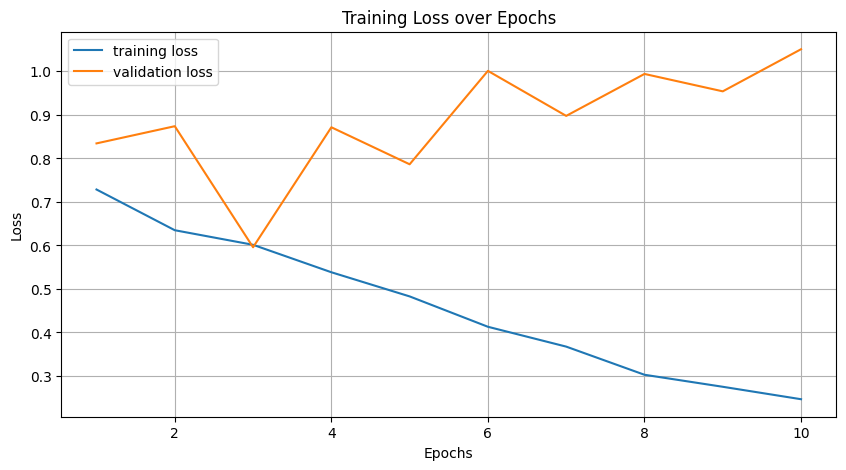

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, losses, label="training loss")
plt.plot(epochs, val_losses, label="validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

In [21]:
model.save_pretrained("model_"+model_serial)

## Evaluation

In [22]:
test_dataset = tokenized_datasets["test"]

prediction = trainer.predict(test_dataset)
prediction = prediction.predictions.argmax(1)

In [23]:
pd.DataFrame(prediction).to_csv(r"result_prediction/prediction_"+model_serial+'.csv',index=False)

In [24]:
df_test=pd.read_csv(r"dataset/train/test.csv")
actual_label = df_test['label']

In [25]:
print(classification_report(prediction, actual_label, target_names=["Negatif", "Netral", "Positif"]))

              precision    recall  f1-score   support

     Negatif       0.88      0.82      0.85        34
      Netral       0.46      0.55      0.50        11
     Positif       0.93      0.93      0.93        46

    accuracy                           0.85        91
   macro avg       0.76      0.77      0.76        91
weighted avg       0.86      0.85      0.85        91



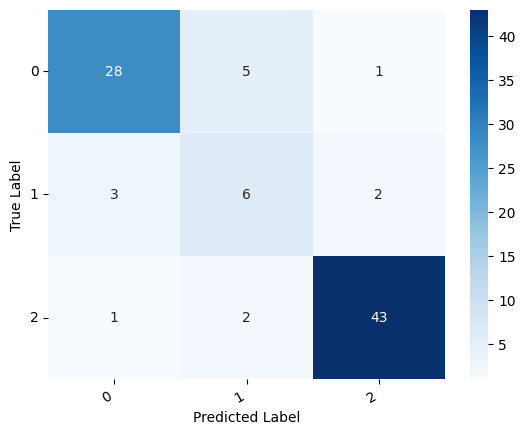

In [26]:
def show_confusion_matrix(confusion_matrix):
        hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
        hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
        hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')

        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')

cm = confusion_matrix(prediction, actual_label)
show_confusion_matrix(cm)

In [27]:
f1_metric.compute(predictions=prediction, references=actual_label, average="weighted")

{'f1': 0.8423243423243424}

## Save Training Result

In [28]:
save_dict = {}
save_dict["trainer_history"] = trainer.state.log_history
save_dict["trainer_args"] = trainer.args.to_dict()
save_dict["trainer_model_config"] = trainer.model.config.to_dict()

In [29]:
with open(r"result_model/result_"+model_serial+'.json', 'w', encoding='utf-8') as f:
    json.dump(save_dict, f, ensure_ascii=False, indent=4)

In [30]:
model_serial

'cahya_250209-234327'